# Pytorch
Marcelo Mandirola
https://pytorch.org/
https://pytorch.org/tutorials/
https://pytorch.org/docs/stable/index.html

Pytorch es un framework de machine learning que nos permite rápidamente diseñar, entrenar y testear modelos de machine learning (en particular, redes neuronales). 

Vamos a utilizar este framework para implementar el obligatorio del curso, por eso, en la clase de hoy vamos a ver una breve introduccion al framework y las redes neuronales. Vamos a prestar detallada atencion a dos tipos de modelos: las redes FeedForward (neuronas que se conectan entre sí en una modalidad de "cascada secuencial").

Este notebook debería servir como base para implementar todas las operaciones necesarias para resolver el obligatorio, así como tambien cualquier otra tarea básica de Deep Learning.

### A Entregar:

- Este mismo notebook con la solucion a todos los problemas planteados. Pueden trabajar en grupos de hasta 3 estudiantes.

In [1]:
import torch
import numpy as np

### Creación de tensores.
Los tensores pueden crearse con listas o numpy arrays

In [2]:
torch.tensor([[1., -1.], [1., -1.]])

tensor([[ 1., -1.],
        [ 1., -1.]])

In [3]:
torch.tensor(np.array([[1, 2, 3], [4, 5, 6]]))

tensor([[1, 2, 3],
        [4, 5, 6]])

In [4]:
torch.zeros([2, 4], dtype=torch.int32)

tensor([[0, 0, 0, 0],
        [0, 0, 0, 0]], dtype=torch.int32)

### Manipulación de tensores.
Los tensores pueden accederse mediante las directivas de slicing y e indexación de python

In [5]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
print(x[1][2])
x[0][1] = 8
print(x)

tensor(6)
tensor([[1, 8, 3],
        [4, 5, 6]])


### Operaciones sobre tensores.

In [6]:
x = torch.tensor([1., 2., 3.])
y = torch.tensor(2)
z = torch.randn(1, 3)

In [7]:
x + y

tensor([3., 4., 5.])

In [8]:
x * y

tensor([2., 4., 6.])

In [9]:
x / y

tensor([0.5000, 1.0000, 1.5000])

In [10]:
r = torch.mv(z, x)
r

tensor([4.1966])

In [11]:
mat1 = torch.randn(2, 3)
mat2 = torch.randn(3, 4)
r = torch.mm(mat1, mat2)
r

tensor([[-0.2964, -0.0471,  0.1307,  0.0922],
        [ 1.4925,  0.0478, -1.3756, -0.4495]])

### Metadata

In [12]:
w = torch.tensor([[1,2,3],[4,5,6]])
print(w.size())                      
print(torch.numel(w))

torch.Size([2, 3])
6


### Resizing (reshaping)

In [13]:
x = torch.randn(2, 3)   
print('Size of x:', x.size())
y = x.view(6) 
print('Size of y:', y.size())
z = x.view(-1, 2) 
print('Size of z:', z.size())

Size of x: torch.Size([2, 3])
Size of y: torch.Size([6])
Size of z: torch.Size([3, 2])


### Cálculo de gradientes
Pytorch habilita al cálculo automático de gradientes (autograd)

In [14]:
x = torch.tensor([[1., -1.], [1., 1.]], requires_grad=True)
print(x.grad)
out = x.pow(2).mean()
print(out)
out.backward()

print(x.grad)

None
tensor(1., grad_fn=<MeanBackward0>)
tensor([[ 0.5000, -0.5000],
        [ 0.5000,  0.5000]])


## Uso automático de GPU

En Colab tenemos 12 Horas de GPU gratis para usar (cambiando el runtime type), esto nos permite entrenar modelos de DL mucho mas rápido. La celda de código abajo detecta si tenemos una GPU disponible o no y nos va a permitir escribir código genérico para cualquier dispositivo.

***
Recomendamos fuertemente utilizar CPU lo más posible mientras probamos código y usar la GPU solo para cuando sabemos que todo funciona y queremos obtener resultados. 

In [15]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

cuda:0


In [16]:
x = torch.rand(2, 900000).cpu()            # Initialize with random number (uniform distribution)
y = torch.randn(900000,200).cpu()           # With normal distribution (SD=1, mean=0)
z = torch.randperm(200).cpu()           # Size 200. Random permutation of integers from 0 to 200

print('CPU time:')
%timeit torch.mm(x,y)+z

x = torch.rand(2, 900000).cuda()            
y = torch.randn(900000,200).cuda()          
z = torch.randperm(200).to(DEVICE)  # Manda al tensor al dispositivo que le pasamos (en este caso cuda:0)

print(' ')
print('GPU time:')
%timeit torch.mm(x,y)+z

CPU time:
112 ms ± 4.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
 
GPU time:
6.33 ms ± 61.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## FeedForward networks

Son la unidad más simple de red neuronal, con su origen en el perceptron de muchas capas. La idea es crear una secuencia lineal de neuronas (capa) que reciben nuestro input. 

![Image](https://upload.wikimedia.org/wikipedia/commons/c/c2/MultiLayerNeuralNetworkBigger_english.png)

De esta manera la primera capa de neuronas (input layer) recibe los datos y las capas subsiguientes reciben el resultados de capas anteriores. La última capa (output layer) es la encargada de generar una predicción a partir de nuestros inputs.

***

En este notebook vamos a usar un dataset muy simple y conocido de imágenes, Fashion-MNIST. Se trata de un dataset de ropa y calzado, la idea es usar redes neuronales para clasificar cada una de las imágenes el tipo de ropa que representa. 

Para trabajar con imagenes vamos a hacer uso de una librería complementaria a Pytorch: **torchvision** (https://pytorch.org/docs/stable/torchvision/index.html) que incluye varios datasets precargados, modelos preentrenados y algunas utilidades para trabajar con imágenes que nos van a resultar útiles.

*** 

En la celda de abajo vamos a carga nuestro dataset y mostrar algunas imagenes de ejemplo.


Tamaño del dataset 60000 imagenes.
Clases posibles: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Objeto imagen: <PIL.Image.Image image mode=L size=28x28 at 0x7FF13D7C4700> - Clase 9
Detalles de la imagen (28, 28) pixeles


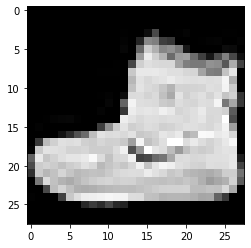

In [17]:
import matplotlib.pyplot as plt
import torchvision.datasets as dsets

mnist_dataset = dsets.FashionMNIST("ruta_donde_guardar_datos", download=True)

print(f"Tamaño del dataset {len(mnist_dataset)} imagenes.")
print(f"Clases posibles: {mnist_dataset.classes}")

data_idx = 0  # Indice (0-59999) de la imagen que queremos ver
image, label = mnist_dataset[0] 

print(f"Objeto imagen: {image} - Clase {label}")
print(f"Detalles de la imagen {image.size} pixeles")

plt.imshow(image, cmap='gray')
plt.show()

### Clasificador

Ahora que tenemos una idea de como es nuestro dataset, vamos a crear un modelo FeedForward para predecir la clase de la imagen que usemos como input. 

Antes que nada, vamos a necesitar dividir el dataset total en conjuntos de **entrenamiento**, **validacion** y **test**. Vamos a usar un ratio de 80 y 20% respectivamente. El set de test se puede descargar por separado con torchvision. Además, vamos a necesitar una manera de cargar **batches** de datos a la vez, para entrenar nuestra red. Pytorch nos proporciona varias ayudas para esto.

***

Finalmente, queda aclarar el uso de **tranformaciones** sobre las imágenes. Por lo pronto, tenemos objetos de tipo PIL Image, necesitamos (al menos) convertirlos en Tensores, para que Pytorch los pueda manejar.

Hay un numero inmenso de transformaciones posibles que podemos usar en nustras imagenes, en este caso basta con tranformarlas a tensores, pero dejamos este link para otros casos: https://pytorch.org/docs/stable/torchvision/transforms.html


In [18]:
#Esto nos permite cambiarle la forma a un tensor aplicandole una transformacion. 

class ReshapeTransform:
    def __init__(self, new_size):
        self.new_size = new_size

    def __call__(self, img):
        return torch.reshape(img, self.new_size)

In [19]:
import torchvision.transforms as transforms

img_transforms = transforms.Compose([transforms.ToTensor(), ReshapeTransform((-1,))])

# Descargamos los datasets
mnist_train_dataset = dsets.FashionMNIST("ruta_donde_guardar_datos", download=True, train=True, transform=img_transforms)

# Separamos el train set en train y validation
train_set, val_set = torch.utils.data.random_split(mnist_train_dataset, [int(0.8 * len(mnist_train_dataset)), int(0.2 * len(mnist_train_dataset))])

mnist_test_dataset = dsets.FashionMNIST("ruta_donde_guardar_datos", download=True, train=False, transform=img_transforms)

# Creamos objetos DataLoader (https://pytorch.org/docs/stable/data.html) que nos va a permitir crear batches de data automaticamente.

# Cuantas imagenes obtener en cada iteracion!
BATCH_SIZE = 64

# Creamos los loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

### Modelo

Vamos a considerar cada imagen como un tensor de una sola dimensión, de largo 28*28 = 784. Cada uno de esos valores representa el valor de un pixel de nuestra imagen original.

Nuestra red va a recibir ese tensor como input (en realidad, un batch de tensores de largo 784) que va a ser trabajado por varias capas ocultas con diferente número de neuronas hasta llegar a una capa de salida con 10 outputs, 1 por cada clase posible.

***

Vamos utilizar capas conectadas totalmente, tambien conocidas como Fully Connected, Dense, o Linear en Pytorch (https://pytorch.org/docs/stable/nn.html). Para crearlas necesitamos especificar las dimensiones del tensor de entrada, y el de salida; luego internamente Pytorch genera la matriz de pesos por los cuales multiplicar la entrada para generar la salida. Luego de cada una de estas operaciones necesitamos usar una funcion de activacion no linear, en este caso, vamos a usar ReLU: https://pytorch.org/docs/stable/nn.html#relu. 

***

Para implementar un modelo **cualquiera** alcanza con definir un metodo **init** donde especificamos la arquitectura del mismo, y un método **forward** donde especificamos cómo interactúan nuestras capas frente a un nuevo input.

***



In [20]:
# Definicion del modelo que vamos a usar. En Pytorch los modelos se definen como clases, que heredan de nn.Module
import torch.nn as nn
import torch.nn.functional as F


class FeedForwardModel(nn.Module):

    def __init__(self, number_classes=10):
        super(FeedForwardModel, self).__init__()
        self.linear1 = nn.Linear(in_features=784, out_features=128)
        self.linear2 = nn.Linear(in_features=128, out_features=64)
        self.output = nn.Linear(in_features=64, out_features=number_classes)
  
    def forward(self, new_input):
        result = F.relu(self.linear1(new_input))
        result = F.relu(self.linear2(result))
        logits = self.output(result)

        return logits


model = FeedForwardModel(number_classes=10)
model

FeedForwardModel(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)

### Entrenando el modelo

Para entrenar un modelo necesitamos una funcion de costo o pérdida (normalmente referida como loss function: https://pytorch.org/docs/stable/nn.html#loss-functions). En este curso no nos vamos a meter en mucho detalle sobre las funciones de costo, para este ejercicio y el siguiente vamos a usar la CrossEntropyLoss, y cuando necesiten otra la vamos a especificar.

El objetivo de esta funcion es darnos un valor de que tan malas fueron las predicciones del modelo respecto a los valores de verdad. Haciendo uso de backpropagation y del gradiente de esta funcion podemos optimizar los pesos de nuestra red tal que "aprenda" a hacer mejores predicciones. De nuevo, la lógica detras de toda esta optimización no nos compete en este curso y lo dejamos para la disciplina de Deep Learning.

***
Como mencionamos arriba, el costo de computa usando las predicciones del modelo y las etiquetas verdaderas de nuestros datos y, el trabajo de actualizar los pesos usando los gradientes lo realiza un optimizador de Pytorch: https://pytorch.org/docs/stable/optim.html.

In [21]:
import torch.optim as optim

LEARNING_RATE = 0.003

ff_model = FeedForwardModel(number_classes=10).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
ff_optimizer = optim.SGD(ff_model.parameters(), lr=LEARNING_RATE, momentum=0.9)

In [22]:
def train_model(model, train_loader, val_loader, loss_func, optimizer, epochs):
    for epoch in range(epochs):  # Iteramos sobre el dataset entero muchas veces

        running_loss = 0.0  

        for i, data in enumerate(train_loader):
            # Nuestros datos son imagenes y la clase de cada una.
            images, labels = data
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Reseteamos los gradientes de los pesos del modelo.
            optimizer.zero_grad()   

            # Obtenemos las predicciones para las nuevas imagenes llamando a nuestro modelo.
            predictions = model(images)    

            # Calulamos el costo de nuestras predicciones respecto a la verdad
            loss = loss_func(predictions, labels)

            # Computamos los gradientes con backward y actualizamos los pesos con un optimizer.step()
            loss.backward()
            optimizer.step()

            # Estadísiticas
            running_loss += loss.item()
            if i % 500 == 499:    # Imprimimos luego de 1000 batches de datos
                print(f"Epoch: {epoch + 1}, Batch: {i + 1} - Loss: {running_loss / 500:.5f}")
                running_loss = 0.0


        # Luego de cada epoch de entrenamiento vemos la performance (accuracy) en el set de validacion
        with torch.no_grad():
            correct_predictions = 0.0

            for i, data in enumerate(val_loader):
                images, labels = data
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)

                predictions = model(images)
                predictions = torch.argmax(predictions, dim=1)

                correct_predictions += (predictions == labels).detach().cpu().float().sum().item()

        print(f"Validation accuracy {(100 * correct_predictions / len(val_loader.dataset)):.2f} %")

    return model

In [23]:
def test_model(model, test_loader):
    # Finalmente Reportamos la performance en el test set:
    with torch.no_grad():
        correct_predictions = 0.0

        for i, data in enumerate(test_loader):
            images, labels = data
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            predictions = model(images)
            predictions = torch.argmax(predictions, dim=1)

            correct_predictions += (predictions == labels).detach().cpu().float().sum().item()

    print(f"Test set accuracy {(100 * correct_predictions / len(test_loader.dataset)):.2f} %")

In [24]:
# Usando las funciones definidas arriba entrenar un modelo es trivial

ff_model = train_model(ff_model, train_loader, val_loader, loss_func=criterion, optimizer=ff_optimizer, epochs=15)
test_model(ff_model, test_loader)

Epoch: 1, Batch: 500 - Loss: 1.25126
Validation accuracy 77.48 %
Epoch: 2, Batch: 500 - Loss: 0.59047
Validation accuracy 82.27 %
Epoch: 3, Batch: 500 - Loss: 0.49796
Validation accuracy 82.99 %
Epoch: 4, Batch: 500 - Loss: 0.46282
Validation accuracy 83.51 %
Epoch: 5, Batch: 500 - Loss: 0.43237
Validation accuracy 84.35 %
Epoch: 6, Batch: 500 - Loss: 0.41490
Validation accuracy 85.17 %
Epoch: 7, Batch: 500 - Loss: 0.39828
Validation accuracy 85.62 %
Epoch: 8, Batch: 500 - Loss: 0.38105
Validation accuracy 85.74 %
Epoch: 9, Batch: 500 - Loss: 0.36834
Validation accuracy 85.92 %
Epoch: 10, Batch: 500 - Loss: 0.35873
Validation accuracy 86.82 %
Epoch: 11, Batch: 500 - Loss: 0.34663
Validation accuracy 86.62 %
Epoch: 12, Batch: 500 - Loss: 0.33702
Validation accuracy 86.81 %
Epoch: 13, Batch: 500 - Loss: 0.32922
Validation accuracy 87.33 %
Epoch: 14, Batch: 500 - Loss: 0.32083
Validation accuracy 87.33 %
Epoch: 15, Batch: 500 - Loss: 0.31455
Validation accuracy 87.64 %
Test set accuracy 8

## Tarea 1

Cree y entrene un modelo de red FeedForward que funcione mejor que el visto en clase. Puede usar lo que considere necesario (siempre dentro del mundo de redes feed forward - nada de convoluciones)

In [35]:
class FeedForwardModel(nn.Module):

    def __init__(self, number_classes=10):
        super(FeedForwardModel, self).__init__()
        self.linear1 = nn.Linear(in_features=784, out_features=356)
        self.linear2 = nn.Linear(in_features=356, out_features=64)
        self.output = nn.Linear(in_features=64, out_features=number_classes)
  
    def forward(self, new_input):
        result = F.relu(self.linear1(new_input))
        result = F.relu(self.linear2(result))
        logits = self.output(result)

        return logits


model = FeedForwardModel(number_classes=10)
model

FeedForwardModel(
  (linear1): Linear(in_features=784, out_features=356, bias=True)
  (linear2): Linear(in_features=356, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)

In [36]:
LEARNING_RATE = 0.001

ff_model2 = FeedForwardModel(number_classes=10).to(DEVICE)
criterion2 = nn.CrossEntropyLoss().to(DEVICE)
ff_optimizer2 = optim.Adam(ff_model2.parameters(), lr=LEARNING_RATE)

In [37]:
ff_model = train_model(ff_model2, train_loader, val_loader, loss_func=criterion2, optimizer=ff_optimizer2, epochs=45)
test_model(ff_model2, test_loader)

Epoch: 1, Batch: 500 - Loss: 0.61473
Validation accuracy 83.88 %
Epoch: 2, Batch: 500 - Loss: 0.39317
Validation accuracy 86.70 %
Epoch: 3, Batch: 500 - Loss: 0.34596
Validation accuracy 87.08 %
Epoch: 4, Batch: 500 - Loss: 0.32058
Validation accuracy 86.97 %
Epoch: 5, Batch: 500 - Loss: 0.29695
Validation accuracy 86.90 %
Epoch: 6, Batch: 500 - Loss: 0.28268
Validation accuracy 87.92 %
Epoch: 7, Batch: 500 - Loss: 0.27242
Validation accuracy 88.18 %
Epoch: 8, Batch: 500 - Loss: 0.25558
Validation accuracy 87.91 %
Epoch: 9, Batch: 500 - Loss: 0.24554
Validation accuracy 87.59 %
Epoch: 10, Batch: 500 - Loss: 0.23499
Validation accuracy 88.33 %
Epoch: 11, Batch: 500 - Loss: 0.22679
Validation accuracy 88.51 %
Epoch: 12, Batch: 500 - Loss: 0.21814
Validation accuracy 89.15 %
Epoch: 13, Batch: 500 - Loss: 0.21066
Validation accuracy 88.89 %
Epoch: 14, Batch: 500 - Loss: 0.20335
Validation accuracy 88.85 %
Epoch: 15, Batch: 500 - Loss: 0.19487
Validation accuracy 89.08 %
Epoch: 16, Batch: 5

# Redes Convolucionales


![Image](https://www.unite.ai/wp-content/uploads/2019/12/Typical_cnn-1.png)


Las redes convolucionales (CNNs) se basan en el uso de una tecnica muy usada en el campo de computer vision tradicional, las **convoluciones** (https://en.wikipedia.org/wiki/Kernel_(image_processing), la idea es crear un filtro pequeño que pasamos por encima de toda la imagen y nos permite detectar distintos elementos (como son líneas verticales, horizontales, diagonales, circulos, etc). EL gran problema de las convoluciones es que para crear dichos filtros debemos poder especificar distintos valores (pesos) para cada región en el mismo. 

Cada filtro (tambien conocido como kernel) nos permite identificar algo en particular en la imágen, y aplicar un filtro al resultado de otro (u otros) nos permite obtener informacion de más alto nivel (como por ejemplo detectar ojos, ruedas, puertas, etc).

![Image](https://d2l.ai/_images/correlation.svg)

***

Las redes convolucionales nos dan una manera de no sólo aprender los vaores óptimos para dichos filtros (mediante backprop) sino tambien la posibilidad de hacerlo a escala usndo un número arbitrario de los mismos. Una gran ventaja que nos trae el uso de filtros, es el hecho de que requieren de un número muy chico de pesos a entrenar, lo que reduce el tamaño de nuestra red y nos permite entrenar mas rápido (o redes mas grandes y profundas con el mismo hardware).

Una cosa a notar en las redes convolucionales es el hecho de que las imágenes se van reduciendo en su tamaño a medida que fluyen por la red, esto se debe a la opeación de `maxpooling` que toma regiones (por lo general de 2x2) en nuestra imagen y se queda con el valor más alto en la zona, reduciendo asi el tamaño de la imagen. El resultado de aplicar un filtro de convolución a una imagen se llama `feature_map` y se puede pensar como otra imagen que describe la características de la original. 

***

Al final de nuestra red, necesitamos formar una predicción de la clase de nuestra imagen, por lo que tenemos que "achatar" estos feature maps y pasarlos por una (o varias) capas lineales que generen una predicción. Esto se puede ver como representar toda la informacion que conocemos de la imagen, como por ejemplo si tiene nariz, orejas, pelo, en un sólo vector; y decidir que ese vector representa a un perro.

***

Para empezar, volvemos a definir nuestros conjuntos de datos. Esta vez, sin hacer uso de ninguna transformacion sobre la imagen (mas que transformarla en un tensor).

In [38]:
import torchvision.transforms as transforms

# Descargamos los datasets
mnist_train_dataset = dsets.FashionMNIST("ruta_donde_guardar_datos", download=True, train=True, transform=transforms.ToTensor())

# Separamos el train set en train y validation
train_set, val_set = torch.utils.data.random_split(mnist_train_dataset, [int(0.8 * len(mnist_train_dataset)), int(0.2 * len(mnist_train_dataset))])

mnist_test_dataset = dsets.FashionMNIST("ruta_donde_guardar_datos", download=True, train=False, transform=transforms.ToTensor())

# Creamos objetos DataLoader (https://pytorch.org/docs/stable/data.html) que nos va a permitir crear batches de data automaticamente.

# Cuantas imagenes obtener en cada iteracion!
BATCH_SIZE = 64

# Creamos los loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

### Modelo Convolucional

Igual que con el modelo FeedForward, para crear un modelo usando convoluciones necesitamos crear una clase, definir los metodos **init** y **forward** y especificar la arcquitectura y comportamiento de los componentes del modelo. 

En particular vamos a usar:

- capas convolucionales de 2D (https://pytorch.org/docs/stable/nn.html#conv2d) a las que tenemos que especificarles la cantidad de canales de entrada (1 para gris, 3 para color y X para el resultado de un filtro anterior), una cantidad de filtros a usar (out_channels), el tamaño de los mismos (kernel_size) y si aplicamos padding (relleno) o no (esto nos permite hacer convoluciones que no modifiquen el tamaño original de las imagenes). 

- Capas de maxpooling (https://pytorch.org/docs/stable/nn.html#maxpool2d) a las que tenemos que decirles el tamaño de la ventana a mirar y el largo del paso que deben tomar (stride).

- Finalmente tambien haremos uso de capas lineales y ReLUs como hicimos anteriormente.

In [39]:
class ConvolutionalModel(nn.Module):
    def __init__(self, number_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding=1)
        
        self.pooling_layer = nn.MaxPool2d(kernel_size=2, stride=2)   # Regiones de 2x2 con paso 2.
        
        # Nuestras imagenes son de 28x28 y vamos a aplicar 2 veces la capa de pooling
        # por lo que el resultado es de tamaño 7x7 (28 / 2 / 2).
        # El 16 es porque terminamos con 16 feature maps de 7x7
        
        self.fc1 = nn.Linear(in_features=7*7*8, out_features=128) 
        
        self.output = nn.Linear(in_features=128, out_features=number_classes)
        

    def forward(self, new_input):
        result = self.conv1(new_input)
        result = F.relu(self.pooling_layer(result))
        
        result = self.conv2(result)
        result = F.relu(self.pooling_layer(result))     
        
        # "Achatamos" los feature maps
        result = result.reshape((-1, self.fc1.in_features))
        result = F.relu(self.fc1(result))
        
        return self.output(result)

In [40]:
conv_model = ConvolutionalModel(number_classes=10).to(DEVICE)

LEARNING_RATE = 0.03

criterion = nn.CrossEntropyLoss().to(DEVICE)
conv_optimizer = optim.SGD(conv_model.parameters(), lr=LEARNING_RATE, momentum=0.9)

conv_model = train_model(conv_model, train_loader, val_loader, loss_func=criterion, optimizer=conv_optimizer, epochs=10)
test_model(conv_model, test_loader)

Epoch: 1, Batch: 500 - Loss: 0.71262
Validation accuracy 86.76 %
Epoch: 2, Batch: 500 - Loss: 0.36003
Validation accuracy 88.59 %
Epoch: 3, Batch: 500 - Loss: 0.30695
Validation accuracy 89.46 %
Epoch: 4, Batch: 500 - Loss: 0.28661
Validation accuracy 89.63 %
Epoch: 5, Batch: 500 - Loss: 0.25971
Validation accuracy 89.16 %
Epoch: 6, Batch: 500 - Loss: 0.24461
Validation accuracy 90.12 %
Epoch: 7, Batch: 500 - Loss: 0.23173
Validation accuracy 90.65 %
Epoch: 8, Batch: 500 - Loss: 0.22182
Validation accuracy 90.29 %
Epoch: 9, Batch: 500 - Loss: 0.20944
Validation accuracy 90.25 %
Epoch: 10, Batch: 500 - Loss: 0.20224
Validation accuracy 90.26 %
Test set accuracy 89.29 %


## Tarea 2

Cree y entrene un modelo de red Convolucional que funcione mejor que el visto en clase. Puede usar lo que considere necesario.

In [43]:
class ConvolutionalModel(nn.Module):
    def __init__(self, number_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        
        self.pooling_layer = nn.MaxPool2d(kernel_size=2, stride=2)   # Regiones de 2x2 con paso 2.
        
        # Nuestras imagenes son de 28x28 y vamos a aplicar 2 veces la capa de pooling
        # por lo que el resultado es de tamaño 7x7 (28 / 2 / 2).
        # El 16 es porque terminamos con 16 feature maps de 7x7
        
        self.fc1 = nn.Linear(in_features=7*7*16, out_features=128) 
        
        self.output = nn.Linear(in_features=128, out_features=number_classes)
        

    def forward(self, new_input):
        result = self.conv1(new_input)
        result = F.relu(self.pooling_layer(result))
        
        result = self.conv2(result)
        result = F.relu(self.pooling_layer(result))     
        
        # "Achatamos" los feature maps
        result = result.reshape((-1, self.fc1.in_features))
        result = F.relu(self.fc1(result))
        
        return self.output(result)

In [44]:
conv_model2 = ConvolutionalModel(number_classes=10).to(DEVICE)

LEARNING_RATE = 0.03

criterion2 = nn.CrossEntropyLoss().to(DEVICE)
conv_optimizer2 = optim.SGD(conv_model2.parameters(), lr=LEARNING_RATE, momentum=0.9)

conv_model = train_model(conv_model2, train_loader, val_loader, loss_func=criterion2, optimizer=conv_optimizer2, epochs=10)
test_model(conv_model2, test_loader)

Epoch: 1, Batch: 500 - Loss: 0.65492
Validation accuracy 86.97 %
Epoch: 2, Batch: 500 - Loss: 0.33917
Validation accuracy 85.97 %
Epoch: 3, Batch: 500 - Loss: 0.28490
Validation accuracy 90.12 %
Epoch: 4, Batch: 500 - Loss: 0.25392
Validation accuracy 90.86 %
Epoch: 5, Batch: 500 - Loss: 0.23200
Validation accuracy 90.70 %
Epoch: 6, Batch: 500 - Loss: 0.21547
Validation accuracy 91.39 %
Epoch: 7, Batch: 500 - Loss: 0.20433
Validation accuracy 91.04 %
Epoch: 8, Batch: 500 - Loss: 0.19128
Validation accuracy 90.67 %
Epoch: 9, Batch: 500 - Loss: 0.17256
Validation accuracy 91.27 %
Epoch: 10, Batch: 500 - Loss: 0.16113
Validation accuracy 91.17 %
Test set accuracy 90.30 %
